# Mean-Variance Portfolio Theory

Constructing a Mean-Standard Deviation Diagram in order to visualize the Efficient Frontier using two methods:

1. Using brute force to generate many random portfolios, and
2. Using quadratic programming to work out a mathematical solution to the Markowitz Problem.

Following the guidance of this [article](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314) as well as this [blog post](https://blog.quantopian.com/markowitz-portfolio-optimization-2/).

## Part 1: Obtaining Data

In [1]:
%load_ext dotenv
%dotenv
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
quandl.ApiConfig.api_key = os.environ.get("API_TOKEN")
stocks = ["AAPL", "AMZN", "FB", "GOOGL", "MSFT", "KORS", "M", "RL"]
stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2014-1-1", "lte": "2015-12-31"}
)
daily_returns = stock_data.set_index("date").pivot(columns="ticker").pct_change()[1:]
daily_returns.columns = stocks

In [3]:
daily_returns.head()

,AAPL,AMZN,FB,GOOGL,MSFT,KORS,M,RL
date,,,,,,,,
2014-01-03,-0.021966,-0.003845,-0.002797,-0.007295,0.001213,0.002810,-0.006728,0.010378
2014-01-06,0.005453,-0.007088,0.048445,0.011149,-0.005696,-0.007284,-0.021132,-0.014166
2014-01-07,-0.007156,0.011178,0.012587,0.019278,-0.037786,-0.018250,0.007750,0.004122
2014-01-08,0.006338,0.009773,0.005352,0.002081,-0.013048,-0.006516,-0.017852,-0.017560
2014-01-09,-0.012772,-0.002264,-0.017345,-0.009630,0.008728,0.076389,-0.006432,0.003250


In [4]:
annual_returns = daily_returns.mean() * 240
variances = daily_returns.var() * 240
covariance_matrix = daily_returns.cov() * 240

## Part 2: Brute Force Random Generation

In [5]:
portfolio_returns = []
portfolio_standard_deviations = []

for _ in range(20000):
    # Randomize weights using the Dirichlet distribution
    # weights = np.random.dirichlet(np.ones(len(stocks)))
    
    # Randomize weights
    w = np.random.random(len(stocks))
    weights = w / sum(w)
    
    # Get return of portfolio
    p_return = np.dot(weights, annual_returns)
    portfolio_returns.append(p_return)
    
    # Get standard deviation of portfolio
    p_variance = np.dot(np.dot(weights.T, covariance_matrix), weights)
    p_standard_deviation = np.sqrt(p_variance)
    portfolio_standard_deviations.append(p_standard_deviation)

portfolios_dict = {
    "Standard Deviations": portfolio_standard_deviations,
    "Returns": portfolio_returns
}

portfolios = pd.DataFrame(portfolios_dict)

In [6]:
portfolios.head()

,Standard Deviations,Returns
0,0.170392,0.068607
1,0.172018,0.089565
2,0.178125,0.066280
3,0.178895,0.123057
4,0.173847,0.042468


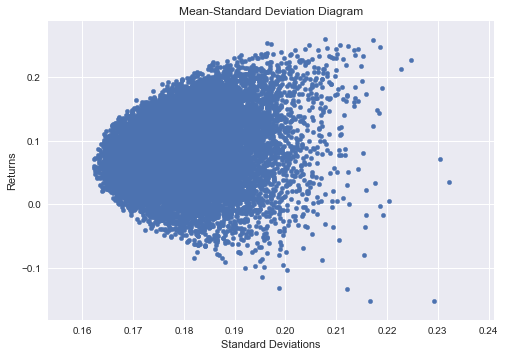

In [7]:
plt.style.use("seaborn")
portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviations",
    y="Returns"
)

## Part 3: Modelling the Markowitz Problem

In [8]:
import cvxopt as opt

In [9]:
# Turn off progress printing 
opt.solvers.options['show_progress'] = False

# Set quadratic variables
n = len(stocks)
N = 100
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
S = opt.matrix(np.array(covariance_matrix))
pbar = opt.matrix(annual_returns)

# Create constraint matrices
G = -opt.matrix(np.identity(n))
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming
optimal_weights = [opt.solvers.qp(mu*S, -pbar, G, h, A, b)["x"] for mu in mus]

# Calculate standard deviations and returns for frontier
optimal_standard_deviations = [np.sqrt(opt.blas.dot(x, S*x)) for x in optimal_weights]
optimal_returns = [opt.blas.dot(pbar, x) for x in optimal_weights]

# Construct optimal portfolios dataframe
optimal_portfolios = pd.DataFrame({"Standard Deviations": optimal_standard_deviations, "Returns": optimal_returns})

# Calculate the 2nd degree polynomial of the frontier curve
m1 = np.polyfit(optimal_returns, optimal_standard_deviations, 2)
x1 = np.sqrt(m1[2] / m1[0])

# Calculate the optimal portfolio
opt_weights = np.array(opt.solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)["x"]).flatten()
opt_return = np.dot(opt_weights, annual_returns)
opt_variance = np.dot(np.dot(opt_weights.T, covariance_matrix), opt_weights)
opt_standard_deviation = np.sqrt(opt_variance)
opt_portfolio = pd.DataFrame({"Standard Deviation": [opt_standard_deviation], "Return": [opt_return]})

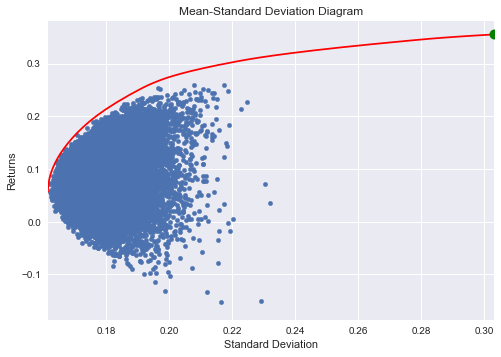

In [10]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviations",
    y="Returns"
)
optimal_portfolios.plot.line(
    x="Standard Deviations",
    y="Returns",
    color="red",
    legend=False,
    ax=ax
)
opt_portfolio.plot(
    x="Standard Deviation",
    y="Return",
    color="green",
    marker="o",
    markersize=10,
    legend=False,
    ax=ax
)

## Part 4: Finding the Highest Sharpe Ratio

In [11]:
risk_free_rate = 0.08

sharpe_ratio = (optimal_portfolios["Returns"] - risk_free_rate) / optimal_portfolios["Standard Deviations"]

sr = pd.DataFrame(sharpe_ratio.rename("Sharpe Ratio"))
sharpe_portfolios = optimal_portfolios.join(sr).sort_values(by=["Sharpe Ratio"], ascending=False)

In [12]:
sharpe_portfolios.head()

,Standard Deviations,Returns,Sharpe Ratio
33,0.225239,0.308033,1.012403
34,0.221673,0.304237,1.011564
32,0.228932,0.311563,1.011494
31,0.233497,0.315524,1.008679
35,0.215696,0.297309,1.007478


In [13]:
max_sharpe = sharpe_portfolios.loc[sharpe_portfolios.idxmax()["Sharpe Ratio"]]
max_sharpe_standard_deviation = max_sharpe["Standard Deviations"]
max_sharpe_return = max_sharpe["Returns"]
sharpest_portfolio = pd.DataFrame({"Standard Deviation": [max_sharpe_standard_deviation], "Return": [max_sharpe_return]})

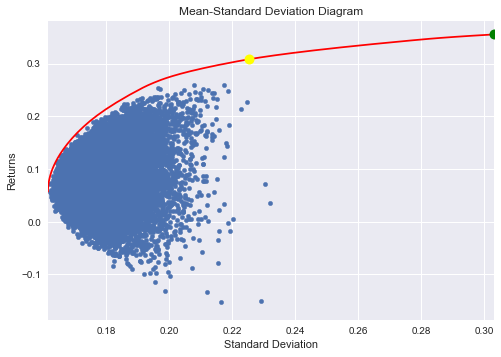

In [14]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviations",
    y="Returns"
)
optimal_portfolios.plot.line(
    x="Standard Deviations",
    y="Returns",
    color="red",
    legend=False,
    ax=ax
)
opt_portfolio.plot(
    x="Standard Deviation",
    y="Return",
    color="green",
    marker="o",
    markersize=10,
    legend=False,
    ax=ax
)
sharpest_portfolio.plot(
    x="Standard Deviation",
    y="Return",
    color="yellow",
    marker="o",
    markersize=10,
    legend=False,
    ax=ax
)